# Set up

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

# Load data

In [1]:
train_data = pd.read_pickle('data/lung_cancer_train.pkl')
test_data = pd.read_pickle('data/lung_cancer_test.pkl')

train_data.head()

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."


# Preprocess

In [3]:
class LungRADSDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data['hu_array'])

    def __getitem__(self, idx):
        img = self.data['hu_array'].iloc[idx]
        mask = self.data['mask'].iloc[idx]

        # Convert to tensor and add channel dimension for grayscale images
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img, mask

In [4]:
flat_imgs = []

for img in train_data['hu_array']:
    flat_imgs.append(img.flatten())

pixels = np.concatenate(flat_imgs)
mean = np.mean(pixels)
std = np.std(pixels)

print(f"Mean: {mean}, Std: {std}")

# Transform pipeline
transform = T.Compose([
    T.Normalize(mean=[mean], std=[std]),
])

Mean: -88.07988303664041, Std: 261.54582149724627


In [5]:
train_dataset = LungRADSDataset(train_data, transform=transform)
test_dataset = LungRADSDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# for img, mask in train_loader:
#     print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')
#     break

Image shape: torch.Size([16, 1, 512, 512]), Mask shape: torch.Size([16, 1, 512, 512])


# Visualize

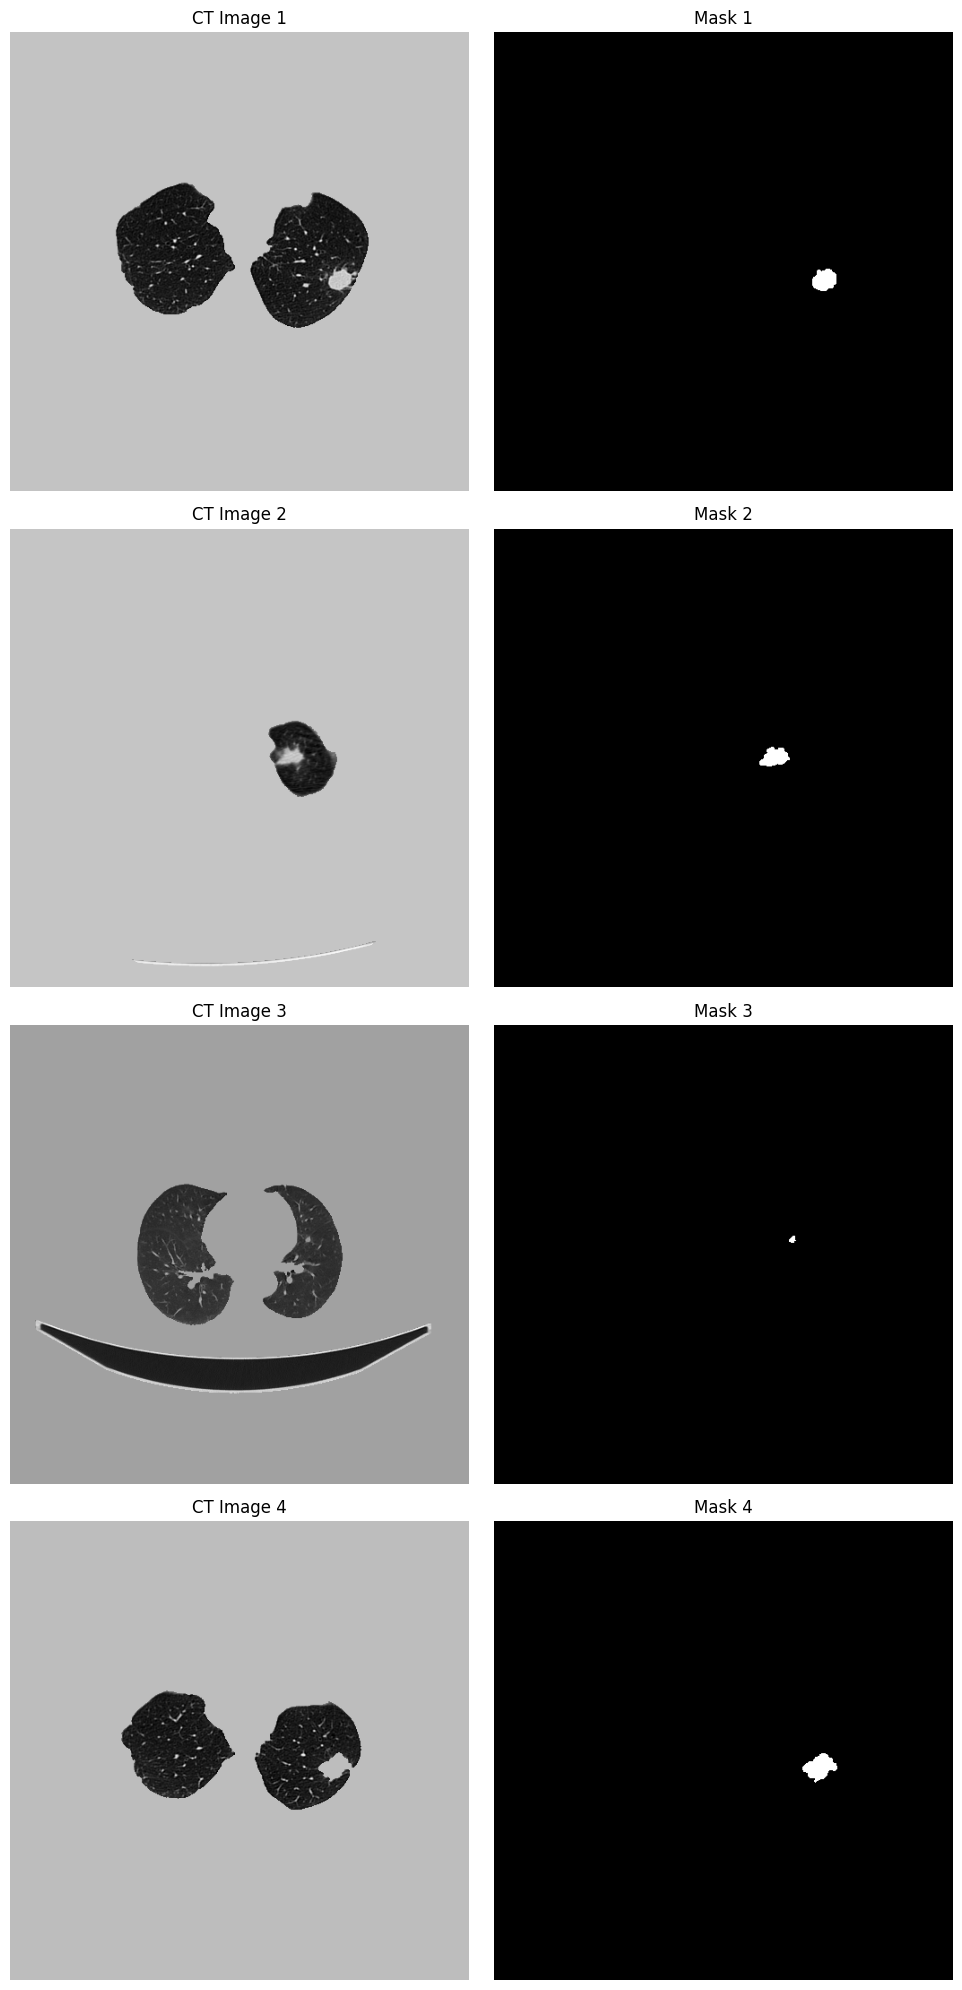

In [12]:
import matplotlib.pyplot as plt

def plot_sample_images(ct_images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = ct_images[i].squeeze().cpu().numpy()  # Remove channel dimension
        mask = masks[i].squeeze().cpu().numpy()

        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f'CT Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a batch (max. 4)
for img, mask in train_loader:
    plot_sample_images(img, mask, num_samples=min(4, img.shape[0]))
    break